In [28]:
import sys
# For data
sys.path.append('/afs/inf.ed.ac.uk/user/s13/s1301730/Documents/discriminitive_turns_project/discriminative_turns/')

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# Global imports
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# Local imports 
from conversational_corpus import *
from discrimination_dataset import *

In [30]:
# Set torch device (if needed...)
# type(swb_dset[1])
import torch
print(torch.cuda.device_count())
print(torch.cuda.current_device())
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))
    
torch.cuda.set_device(3)

4
3
GeForce GTX 1080 Ti
GeForce GTX 1080 Ti
GeForce GTX 1080 Ti
GeForce GTX 1080 Ti


# Notebook for building the lexical discrimination surveys 
Use BERT-FP to sample upcoming responses

## Load the BERT-FP model

In [4]:
from FPT.swb_final import BERTDataset, InputExample, convert_example_to_features
from transformers import BertTokenizer,BertConfig, BertForPreTraining

sys.path.append('Fine-Tuning/')
from BERT_finetuning import NeuralNetwork as NeuralNetwork
from BERT_concat_finetuning import NeuralNetwork as NeuralNetwork_concat

# Create the fine-tuning datasets
base_args = {
    'bert_model': 'bert-base-uncased', 
    'do_lower_case': True, 
    'gradient_accumulation_steps': 1, 
    'learning_rate': 1.5e-05, 
    'max_seq_length': 240, 
    'num_train_epochs': 25.0, 
    'output_dir': './FPT/PT_checkpoint/switchboard', 
    'train_batch_size': 8, 
    'train_file': './spoken_data/swb_train_small.pkl', 
    'warmup_proportion': 0.01
        }


tokenizer = BertTokenizer.from_pretrained(base_args['bert_model'], do_lower_case=base_args['do_lower_case'])

special_tokens_dict = {'eos_token': '[eos]'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)


12/06/2022 14:58:03 - INFO - transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /disk/scratch/swallbridge/BERT_FP/temp_cache/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
12/06/2022 14:58:03 - INFO - transformers.tokenization_utils -   Adding [eos] to the vocabulary
12/06/2022 14:58:03 - INFO - transformers.tokenization_utils -   Assigning [eos] to the eos_token key of the tokenizer


In [5]:
# Load model through Response_selection script
class Bunch(object):
    def __init__(self, adict):
        self.__dict__.update(adict)

args_dict = base_args.copy()
model_args_dict = {
    'task': 'switchboard', 
#     'is_training': , 
    'batch_size': 16, 
    'learning_rate': 1e-5, 
    'epochs': 5, 
    'save_path': './fine-tune/pretrained_swb_samples/', 
    'score_file_path': "./Fine-Tuning/scorefile.txt", 
    'do_lower_case': True, 
    'checkpoint_path': '',
    }
args_dict.update(model_args_dict)
args = Bunch(args_dict)

# Load the base BERT model
model = NeuralNetwork(args=args)   

12/06/2022 14:58:03 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /disk/scratch/swallbridge/BERT_FP/temp_cache/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
12/06/2022 14:58:03 - INFO - transformers.configuration_utils -   Model config BertConfig {
  "_num_labels": 1,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id":

Loaded BERT from pre-trained (bert-base-uncased)


In [6]:
# (sanity check) the weights are different from the loaded BERT (Y) 
display(model.bert_model.state_dict()['bert.embeddings.word_embeddings.weight'][0][:10])
display(model.bert_model.state_dict()['bert.encoder.layer.11.attention.output.LayerNorm.bias'][0])


tensor([-0.0102, -0.0615, -0.0265, -0.0421,  0.0012, -0.0283, -0.0445, -0.0225,
        -0.0047, -0.0821], device='cuda:3')

tensor(-0.0313, device='cuda:3')

In [7]:
# Load PTFT (Post-trained + Fine-tuned) checkpoint
# checkpoint_path = './fine-tune/finetune_swb_samples/switchboard.0.pt'
checkpoint_path = './fine-tune/finetune_32_wts_nxt_20/switchboard_wts_nxt.0.pt'
model.load_model(checkpoint_path)

# (sanity check) the weights are different from the loaded BERT (Y) 
display(model.bert_model.state_dict()['bert.embeddings.word_embeddings.weight'][0][:10])
display(model.bert_model.state_dict()['bert.encoder.layer.11.attention.output.LayerNorm.bias'][0])


Loading model from ./fine-tune/finetune_32_wts_nxt_20/switchboard_wts_nxt.0.pt


tensor([-0.0056, -0.0647, -0.0278, -0.0440,  0.0025, -0.0323, -0.0414, -0.0295,
        -0.0066, -0.0824], device='cuda:3')

tensor(-0.0259, device='cuda:3')

## Load the data
Using word-time-stamp segmentation (modified TTD), where the val+test segments are the NXT subset of SWB

In [31]:
# Load the corpus data
with open( "/disk/scratch/swallbridge/pickles/wts_corpus.p", 'rb' ) as fp:
    wts_corpus = pickle.load(fp)

In [46]:


# # Load discriminative dataset
# wts_path = './spoken_data/wts_nxt_info_da_val_test.pkl'
# discrim_dataset = DiscriminationDataset(wts_path, tokenizer)

# with open('/disk/scratch/swallbridge/pickles/wts_dataset.p', 'wb') as fp:
#     pickle.dump(discrim_dataset, fp)


# with open("/disk/scratch/swallbridge/pickles/wts_dataset.p", 'rb' ) as fp:
#     discrim_dataset = pickle.load(fp)



In [33]:
with open('./spoken_data/wts_nxt_info_da_val.pkl', 'rb') as fp:
    wts_val = pickle.load(fp)

In [34]:
wts_val[5][:3]

[{'clean_text': 'you ready okay what have you seen lately',
  'start': 0.565375,
  'stop': 4.075375,
  'speaker': 'A',
  'conv_id': 'sw3144',
  'DA': [('yn_q', 2), ('acknowledge', 1), ('wh_q', 5)],
  'turn_id': 0,
  'max_DA': 'wh_q'},
 {'clean_text': "well uh it's funny when i tried to make the call the other days i thought i hadn't seen anything since dances with wolves but today i went to see regarding with henry",
  'start': 4.237,
  'stop': 14.637,
  'speaker': 'B',
  'conv_id': 'sw3144',
  'DA': [('hold', 14), ('statement', 19)],
  'turn_id': 1,
  'max_DA': 'statement'},
 {'clean_text': "oh i'm dying to see that",
  'start': 14.7325,
  'stop': 16.447,
  'speaker': 'A',
  'conv_id': 'sw3144',
  'DA': [('statement', 6)],
  'turn_id': 2,
  'max_DA': 'statement'}]

In [50]:
def show_experiment(dataset, corpus, sample_id, n_negs=1000-1, model=model, reverse=False, audio=False):
    # Make BERT-FP predictions
    tokenized_samples, ys, lines = dataset.make_cr_sample(sample_id, n_negs)
    context_lines, response_lines = lines
    y_pred = model.predict({'cr':tokenized_samples, 'y':ys}, pred_batch_size=100)

    top_scores, top_ids, top_lines, sort_ids = select_neighbours(y_pred, tokenized_samples, 
                                                                 response_lines, 1000, 
                                                                 reverse=reverse
                                                                )

    target_id = np.argwhere(sort_ids == 0)[0][0]
    target_score = top_scores[target_id]

    # PRINT AND PLOT
    # Plot
    fig, axs = plt.subplots(2,1, figsize=(10,10))
    axs[0].hist(top_scores)
    axs[1].scatter(range(len(top_scores)), top_scores, )
    axs[1].axhline(target_score)
    axs[1].axvline(target_id, label=f'True response ({target_id})')
    axs[1].set_xlabel('Responses')
    axs[1].set_ylabel('CR score')
    axs[1].legend()
    plt.show()

    print(f'True turn: #{target_id}')
    print(f'CONTEXT: ({context_lines[-1]["conv_id"]}, {context_lines[-1]["turn_id"]})')
    print(f'A: {context_lines[0]["clean_text"]}')
    print(f'B: {context_lines[1]["clean_text"]}')
    print(f'A: {context_lines[2]["clean_text"]}')

    print('RESPONSES')
    for i, ss in enumerate(top_scores[:10]):
        if target_id == i:
            print(f' *** - ({i}) {ss:.3f}, {top_lines[i]["clean_text"]} ({top_lines[i]["conv_id"]}, {top_lines[i]["turn_id"]})')
        else:
            print(f' - ({i}) {ss:.3f}, {top_lines[i]["clean_text"]} ({top_lines[i]["conv_id"]}, {top_lines[i]["turn_id"]})')

    print(f' -  (TRUE RESPONSE) ({target_id}) {ss:.3f}, {top_lines[target_id]["clean_text"]} ({top_lines[target_id]["conv_id"]}, {top_lines[target_id]["turn_id"]})')   
    print('\n----------\n')
    if audio:
        play_experiment(y_pred, tokenized_samples, context_lines, response_lines, corpus, reverse=reverse)
        

Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100


Prediction dataloader: 10it [00:07,  1.37it/s]


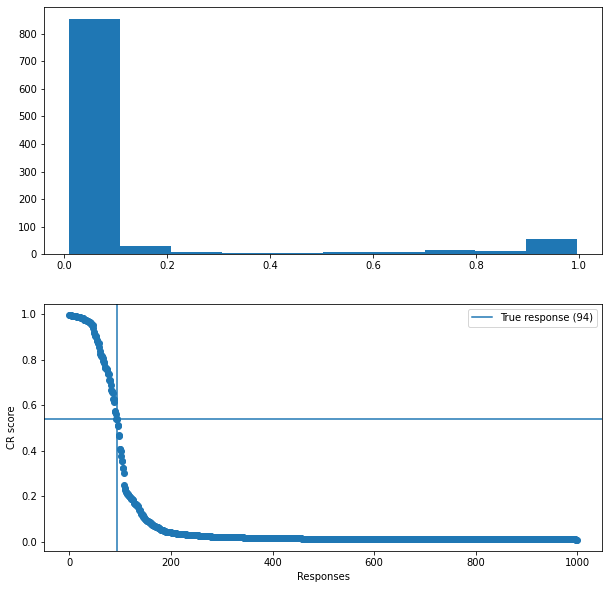

True turn: #94
CONTEXT: (sw2324, 45)
A: uhuh
B: it may be arrogant but i mean let them come to us that's kind of the way i feel about it we can convert
A: and and if they don't like the way we do it just get off our don't worry about it and i think
RESPONSES
 - (0) 0.996, if we have a problem with our connection and get disconnected some time or other don't worry about it we have a a very small phone company down here (sw2093, 31)
 - (1) 0.995, i think that we're too easy (sw2525, 85)
 - (2) 0.995, and i think that's what it is gonna have to come to where we're just forced to (sw3876, 13)
 - (3) 0.994, feel like we've accomplished a little bit here (sw3768, 53)
 - (4) 0.994, yeah good luck to you (sw2772, 133)
 - (5) 0.993, perform this conversion anyway (sw2669, 49)
 - (6) 0.993, i do too i (sw4733, 12)
 - (7) 0.992, leave (sw4720, 30)
 - (8) 0.992, i want to believe they go into other countries and teach them how to do things like farm (sw2657, 28)
 - (9) 0.992, i'm just real surpris

In [51]:
show_experiment(discrim_dataset, wts_corpus, 12)

Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100


Prediction dataloader: 10it [00:07,  1.38it/s]


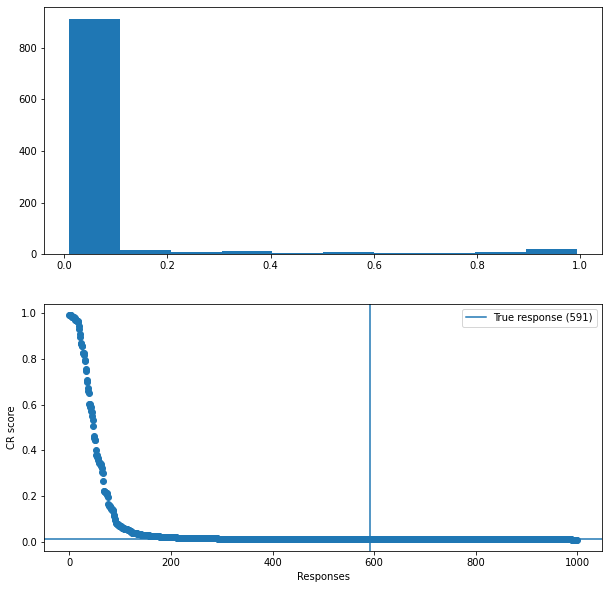

True turn: #591
CONTEXT: (sw2324, 48)
A: yeah it it's kind of like expecting expecting everyone to suddenly speak german
B: right it is because it is another language yeah
A: yeah and and instead of having the world speak german we found out that we can translate and that's what i think we ought to do with the metric system
RESPONSES
 - (0) 0.993, i think that's right i think i think helping us be more enthusiastic enthusiastic about it (sw2876, 68)
 - (1) 0.993, but there's still a lot more we can do (sw2299, 6)
 - (2) 0.992, you know and and maybe come up with a better system make it a little more convenient but i (sw4483, 56)
 - (3) 0.992, right right well that's a real good idea (sw2485, 147)
 - (4) 0.990, so we kind of discussed that a little bit and shot that idea down right quick (sw3275, 36)
 - (5) 0.986, and just start at square one (sw3565, 24)
 - (6) 0.985, i think we're finally beginning to make progress but just not very fast (sw3135, 81)
 - (7) 0.982, anyway we both a sor

Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100


Prediction dataloader: 10it [00:07,  1.38it/s]


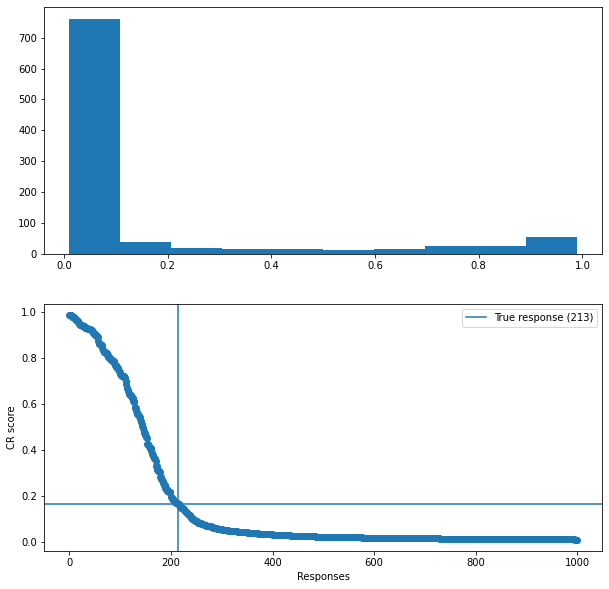

True turn: #213
CONTEXT: (sw4071, 47)
A: right hm
B: doesn't seem fair to me
A: yeah it isn't there's not much out there that's fair that's for sure
RESPONSES
 - (0) 0.989, fantastic one one thing that pops into my mind real quick is uh about the uh funding of the the school system right now (sw2461, 3)
 - (1) 0.989, teachers are out there giving drugs and selling drugs (sw3331, 34)
 - (2) 0.988, okay well i think we're we're we've done okay though well thank you for calling (sw2113, 99)
 - (3) 0.988, well it was nice to talk to you (sw2405, 105)
 - (4) 0.988, i think that's true well i think i'm that's about my uh (sw2876, 88)
 - (5) 0.985, not the fact that there was a big auto accident down at the corner of broad and main you know (sw4177, 14)
 - (6) 0.981, nothing comes to mind right off so i guess not (sw2124, 59)
 - (7) 0.981, well jack it was nice to talk to you (sw2678, 104)
 - (8) 0.979, it was a pleasure talking you (sw3186, 74)
 - (9) 0.975, all right well i enjoyed the conv

Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100


Prediction dataloader: 10it [00:07,  1.37it/s]


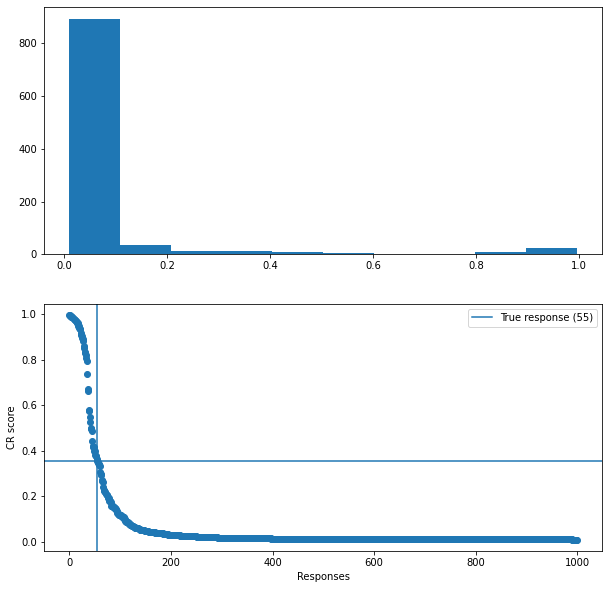

True turn: #55
CONTEXT: (sw3097, 95)
A: um well in the first place it's not your homework it's your children's homework
B: uhuh
A: and i was always very careful to be there only when they came to me and asked me for help i helped them with exactly what they asked for and that's all
RESPONSES
 - (0) 0.996, well it's nice nice talking to you (sw3205, 41)
 - (1) 0.996, well that's that's all right (sw4347, 51)
 - (2) 0.993, all right well i've enjoyed talking to you (sw2093, 67)
 - (3) 0.991, i have a similar problem i've got to have time or i don't even want to get into it in the first place (sw2397, 63)
 - (4) 0.988, that worked out very well for you (sw3120, 40)
 - (5) 0.987, you had to have the help didn't you (sw3327, 46)
 - (6) 0.986, good well i guess i'll let you go now (sw3993, 80)
 - (7) 0.981, yeah and i found that a particularly useless way of studying (sw2362, 80)
 - (8) 0.980, well that's good too (sw2667, 61)
 - (9) 0.977, that and i i did the same thing (sw2703, 32)
 -  (T

Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100


Prediction dataloader: 10it [00:07,  1.37it/s]


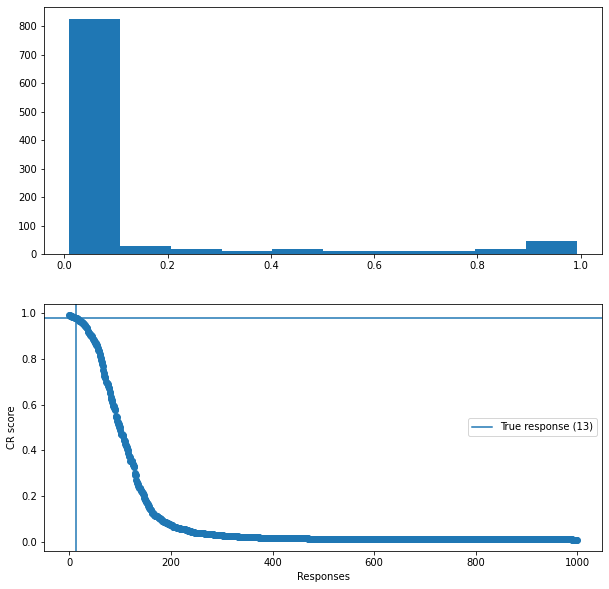

True turn: #13
CONTEXT: (sw2547, 95)
A: maybe a little bit higher than that now
B: that's
A: but that same house here you'd pay almost six thousand dollars a year taxes on it
RESPONSES
 - (0) 0.992, yep but it well you know we it's it's only a state taxes no local we've got a five percent sales tax (sw4181, 18)
 - (1) 0.992, yeah i know and that's (sw2279, 128)
 - (2) 0.989, a little bit much oh yeah yep yep (sw3040, 53)
 - (3) 0.989, that's not bad (sw4171, 12)
 - (4) 0.988, i know but they try every year and every year they get thrown out it's so stupid because they let you take it in there but they don't they don't allow you to sell it don't allow them to sell it there (sw2078, 49)
 - (5) 0.986, and we bought it from someone who was in it but before they had it i found out after i had been in the house it had it had sat empty for the better part of a year (sw3517, 59)
 - (6) 0.985, higher taxes yeah (sw4707, 32)
 - (7) 0.985, yeah i i it's it's it's something definitely that uh yeah

Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100


Prediction dataloader: 10it [00:07,  1.37it/s]


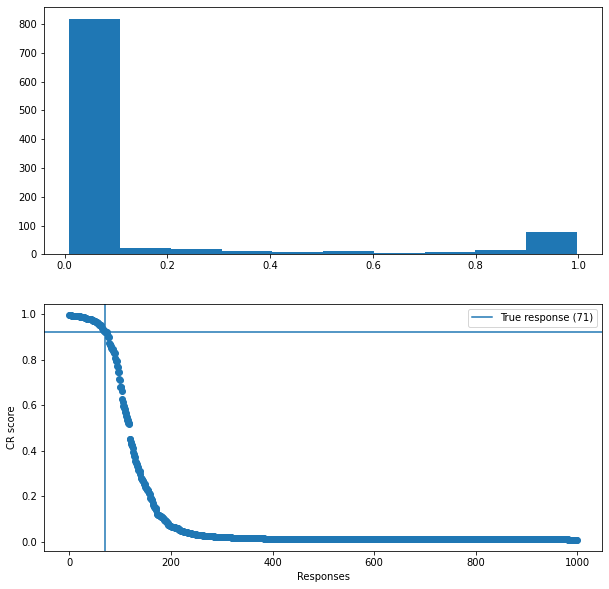

True turn: #71
CONTEXT: (sw2938, 87)
A: and uh the the epa and they were just screening some candidates and i don't think i'd ever you know do that but they uh asked me if i was a smoker and i didn't fit into the smoker's category and i didn't fit into the nonsmoker's category um it was you know i was just one of those
B: yeah because you do smoke one a day
A: yeah in between people so that kind of threw them off
RESPONSES
 - (0) 0.997, at a rate greater than one a day (sw3111, 23)
 - (1) 0.995, it was like you know that was the only reason i quit i didn't want to and i don't want to quit smoking i enjoy that i said i have very few vices i'll keep this one thank you (sw2893, 57)
 - (2) 0.995, i didn't think we could go too far on this privacy thing but uh i guess it's close enough (sw2139, 108)
 - (3) 0.995, so i don't know if i wasn't drug tested based on that or because the man who hired me didn't request the drug test because i know that my company does drug testing on occasion (sw2

Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100


Prediction dataloader: 10it [00:07,  1.37it/s]


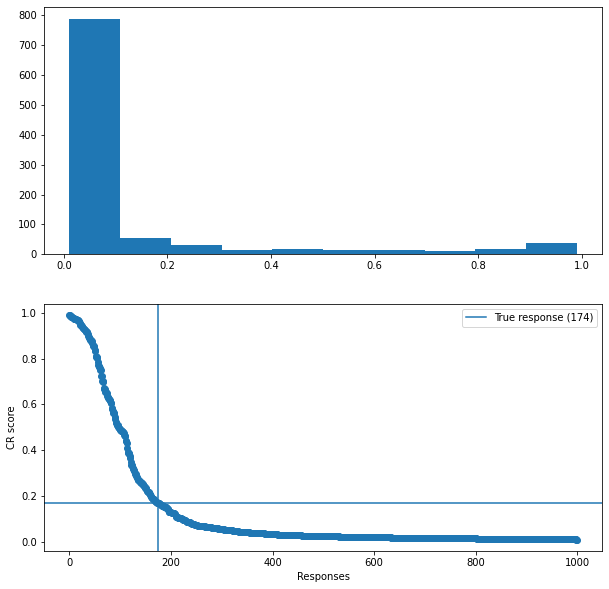

True turn: #174
CONTEXT: (sw3171, 41)
A: mhm
B: so it's
A: so that's perfect what more could you ask for
RESPONSES
 - (0) 0.990, good good question probably taking (sw2362, 95)
 - (1) 0.989, okay well i i think we have exhausted my pitifully small knowledge on (sw2302, 47)
 - (2) 0.985, anyway it's a tough question (sw2349, 87)
 - (3) 0.984, that's what yeah well (sw2826, 32)
 - (4) 0.982, but since last time we've gotten more like a dollar (sw3236, 50)
 - (5) 0.982, i guess that's most of my um financial plans right now is is there anything you'd like to add (sw2022, 68)
 - (6) 0.979, it's better than nothing (sw3236, 24)
 - (7) 0.978, oh another thing i've got a i've got a degree from another college (sw3232, 69)
 - (8) 0.977, well it's what it truly is supposed to mean is nine weeks of school three weeks of vacation (sw3093, 46)
 - (9) 0.973, i see well congratulations on that (sw2653, 18)
 -  (TRUE RESPONSE) (174) 0.973, that's right but if this (sw3171, 42)

----------



Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100


Prediction dataloader: 10it [00:07,  1.37it/s]


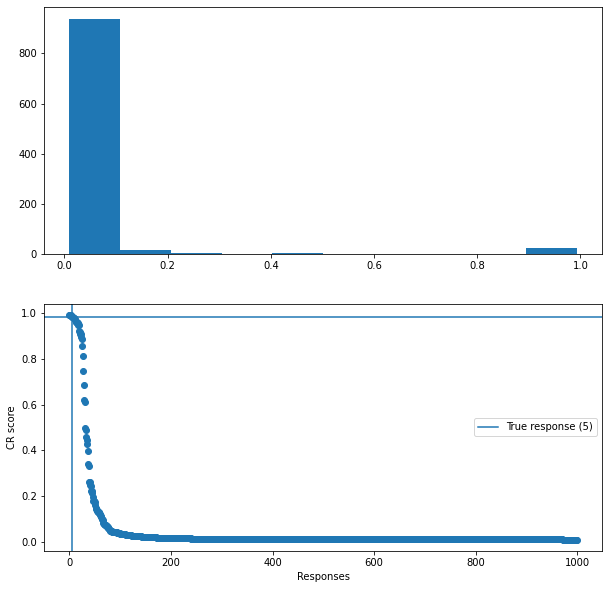

True turn: #5
CONTEXT: (sw2615, 55)
A: yeah well i'd bought uh a gmc diesel pickup and uh loved that thing you know i really liked it but it turns out a pickup wasn't what i really
B: yeah
A: needed and it was the van that i needed then to buying the you know traded it in on the chevy van but uh i sure enjoyed it
RESPONSES
 - (0) 0.993, yeah yeah and needed need to take the little one (sw3636, 53)
 - (1) 0.992, i really enjoy (sw3056, 47)
 - (2) 0.991, well i think the next car we get will probably be a well i i like buicks we have a buick century now it's a nineteen eighty seven (sw4339, 20)
 - (3) 0.991, thoroughly enjoyed it and and it's really a a blast my wife hates it but that's the way life is i guess (sw2072, 18)
 - (4) 0.987, just a nice comfortable ride (sw3411, 20)
 *** - (5) 0.983, you got the three fifty in the van (sw2615, 56)
 - (6) 0.982, well the the ones that we were test driving were the uh were the new ones there (sw2439, 29)
 - (7) 0.982, well it was nice to talk t

In [52]:
for i in [5,298,64,790,403,1002,2003]:
    show_experiment(discrim_dataset, wts_corpus, i+10)


Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100


Prediction dataloader: 10it [00:07,  1.37it/s]


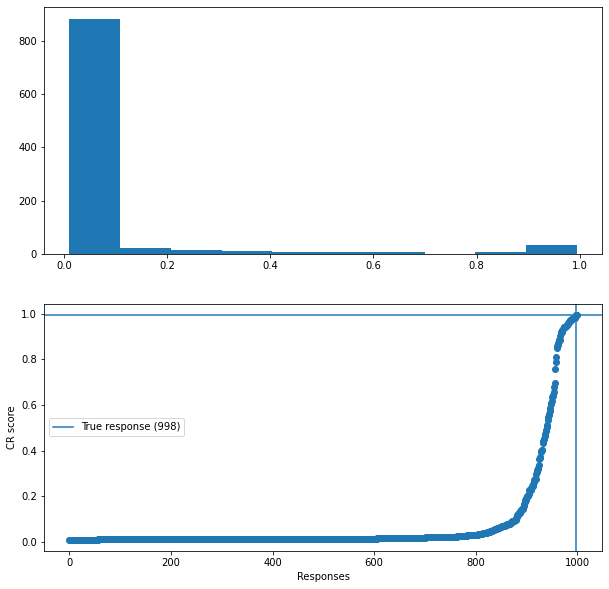

True turn: #998
CONTEXT: (sw2324, 47)
A: and and if they don't like the way we do it just get off our don't worry about it and i think
B: yeah it it's kind of like expecting expecting everyone to suddenly speak german
A: right it is because it is another language yeah
RESPONSES
 - (0) 0.010, it's uh marketed of course it its own dealerships usually usually or somebody that's maybe got a cadillac or lincoln and lexus dealership uh sometimes they do that but (sw3639, 13)
 - (1) 0.010, sometimes i i want to plant something there's not enough room to plant it (sw2427, 13)
 - (2) 0.010, yeah i'm looking i've i've already been to one game and in fact i should have been to two but (sw2565, 65)
 - (3) 0.010, i had a sixty six mustang that i was rebuilding but i almost had it done and i went on went ahead and sold it (sw3349, 20)
 - (4) 0.010, because that's a lot of fun especially this time of year where it's so nice out (sw3229, 2)
 - (5) 0.010, okay and and in in in his league do they have l

Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100


Prediction dataloader: 10it [00:07,  1.37it/s]


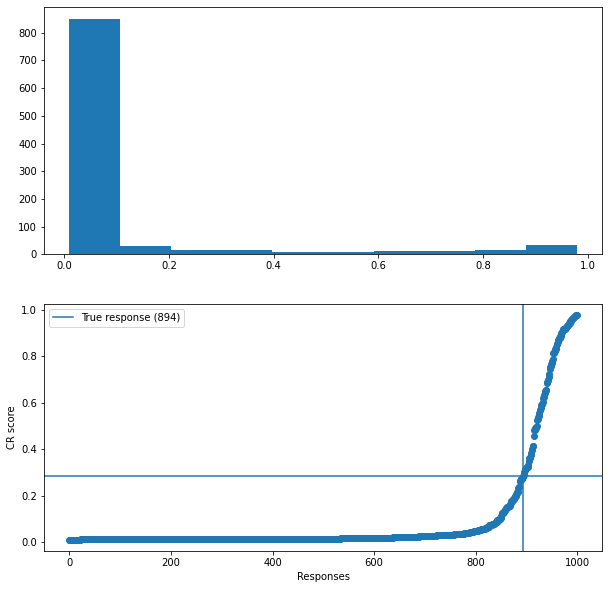

True turn: #894
CONTEXT: (sw3154, 14)
A: oh of course that they did you know actually we had milk delivered to our house
B: oh
A: in glass bottles and we had a milk shoot at the side of the house
RESPONSES
 - (0) 0.010, right now that's about well right now i'm on two teams so it's four nights a week but uh uh so i enjoy it but (sw2789, 16)
 - (1) 0.010, this is the first year we're staying home too and uh i think it's going to be real quiet but uh that's an opportunity to get out the games and (sw3615, 60)
 - (2) 0.010, or either they'd trade him off to somebody else for two of these nobodies (sw2521, 82)
 - (3) 0.010, that's the thing if woman's role like we said if women's roles change drastically men's roles will too (sw2370, 121)
 - (4) 0.010, yeah even in washington you know there seems to be lot more women involved (sw2018, 33)
 - (5) 0.010, no i don't well i i do i like ice skating and i like uh gymnastics (sw3073, 66)
 - (6) 0.010, well it's it's it's not it's not music it's j

Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100


Prediction dataloader: 10it [00:07,  1.37it/s]


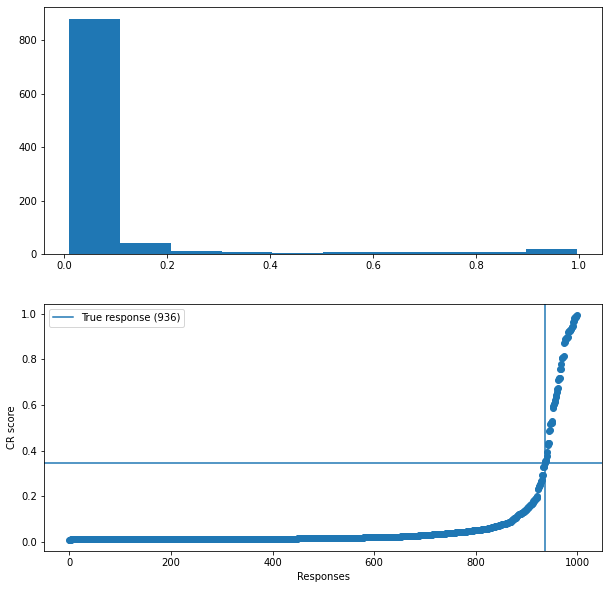

True turn: #936
CONTEXT: (sw4633, 10)
A: to have them uh
B: i try to fool everybody
A: i think you're doing a good job i just have one child
RESPONSES
 - (0) 0.010, double whammy because like you say if you cut defense well that's great that's gonna lower our national expenditures but then you're gonna have people on welfare and they're not putting taxes in (sw4181, 63)
 - (1) 0.010, and so how do you relate as to whether this particular armed robbery was a you know worth five years or twenty five (sw3113, 9)
 - (2) 0.010, yeah uh well it's it's more than a loaded it's a loaded cannon i mean they've got trillions of dollars to spend every year and they in my opinion don't do a very responsible job of spending that money (sw4022, 42)
 - (3) 0.010, oh see i didn't really care that's that's one side of the action i guess that i didn't really care for but see i don't really like sylvester stallone (sw2568, 76)
 - (4) 0.010, well you know the funny thing i find about american opinion is tha

Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100


Prediction dataloader: 10it [00:07,  1.37it/s]


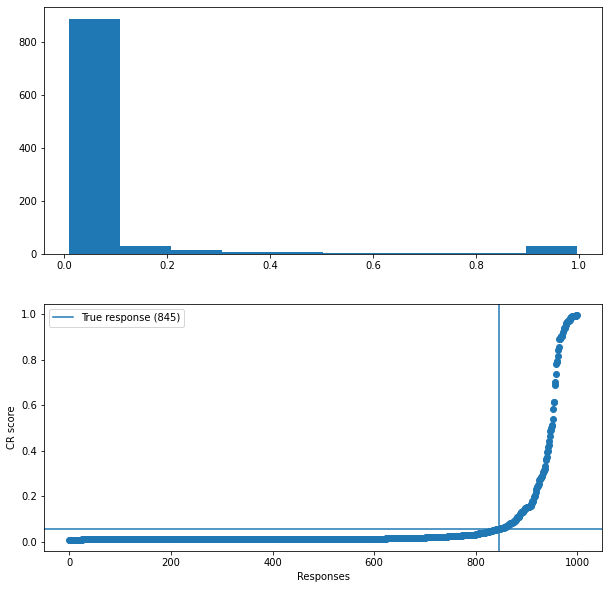

True turn: #845
CONTEXT: (sw3284, 39)
A: and uh they they promote service on the part of the kids to to uh some of those people so at least that's a step in the right direction i guess
B: yeah yeah at uh now i didn't i don't know it did i i think you're right that that that's not the not the way that the society these days is going and i i think we need to we need to try to figure out some way to to turn that around that everybody
A: yeah it's really it's really unfortunate because when you do i do volunteer work for the american lung association
RESPONSES
 - (0) 0.010, i mean it's good because they they try new things you know but it's like they'll try something and then they throw it out and get something else you know and you get tired of that (sw2078, 80)
 - (1) 0.010, yeah and it's it's just about six feet long it rolls up (sw3473, 54)
 - (2) 0.010, no i don't well i i do i like ice skating and i like uh gymnastics (sw3073, 66)
 - (3) 0.010, it's its amazing i love those movies i 

Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100


Prediction dataloader: 10it [00:07,  1.37it/s]


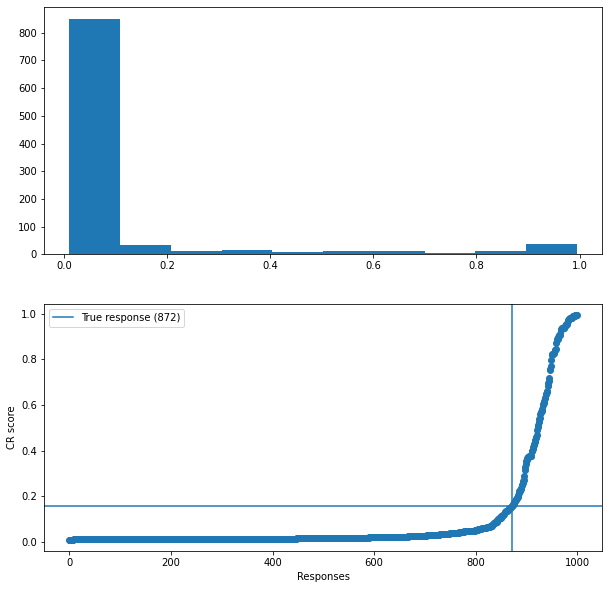

True turn: #872
CONTEXT: (sw3097, 30)
A: right
B: then i went back to work
A: right and that will come i know that day will come and i am looking forward to that too
RESPONSES
 - (0) 0.010, no i don't i have a friend who has a little inflatable inflatable raft and we use that sometimes i wish i had a boat but i don't (sw3342, 21)
 - (1) 0.010, yeah that's uh that's strange with me you know you think dallas you know almost semitropical you wouldn't have that kind of that kind of problem but (sw3251, 48)
 - (2) 0.010, oh yeah um you're not supposed to i mean you're not supposed to eat them dead i mean well you eat them dead but (sw2429, 18)
 - (3) 0.010, yeah a lot of times you can do that think the i think the pinks there's like forty two different shades of pink (sw2053, 32)
 - (4) 0.010, oh okay the yeah that's the one i wanted to see where he was on she was on a carnival at a carnival on a ferris wheel or something (sw2913, 88)
 - (5) 0.010, they're better but how about all the truck

Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100


Prediction dataloader: 10it [00:07,  1.37it/s]


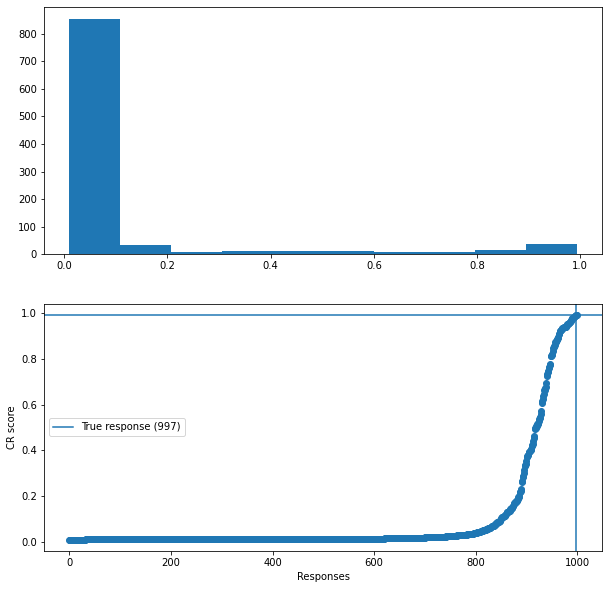

True turn: #997
CONTEXT: (sw2109, 19)
A: two diametrically opposed people from the stand point that one was jewish and one was black
B: oh my
A: and this all took place in the south and uh normally never the twain shall meet
RESPONSES
 - (0) 0.010, yeah well honda does too that's why i was really (sw2526, 12)
 - (1) 0.010, uhuh that's just fantastic down there take it more as a this is your opportunity to do whatever you want pick out where you want to live and then once you pick that spot out pick out what you want to do (sw2645, 93)
 - (2) 0.010, but mostly petty things and nothing nothing nothing nothing really too big (sw4336, 6)
 - (3) 0.010, yeah we camp year round (sw3663, 28)
 - (4) 0.010, i don't even know much money my sister spent on hers but i i just thought i it's it's going to be a waste she's not going to do it not going to use it oh well (sw2545, 80)
 - (5) 0.010, so it's a lot of fun i worked up there last summer so i guess it was kind of like a vacation the whole summ

In [53]:
# WTS stimuli (reversed)
for i in [4,8,325,653,43,346]:#[5,298,64,790, ]:
    show_experiment(discrim_dataset, wts_corpus, i+10, reverse=True)

In [ ]:
sample_id = 10
n_neighbours = 4

dataset = discrim_dataset
corpus = wts_corpus
n_negs = 500-1
model = model
reverse = False
audio = False

tokenized_samples, ys, lines = dataset.make_cr_sample(sample_id, n_negs)
context_lines, response_lines = lines
y_pred = model.predict({'cr':tokenized_samples, 'y':ys}, pred_batch_size=100)

sids = np.argsort(y_pred)
top_scores, top_ids, top_lines, sort_ids = select_neighbours(y_pred, tokenized_samples, 
                                                             response_lines, 500, 
                                                             reverse=reverse
                                                            )

# Return the negatives and target responses
num_negs = n_neighbours
if target_id <= n_negs:
    num_negs = top_lines[:n_neighbours + 1]
    
neg_lines = [response_lines[i] for i in sort_ids[:num_negs] if i != 0]
neg_scores = [y_pred[i] for i in sort_ids[:num_negs] if i != 0]

target_id = np.argwhere(sort_ids == 0)[0][0]
target_response = response_lines[target_id]
target_score = top_scores[target_id]



# PRINT AND PLOT
print(context_lines[2])

In [ ]:
# response_lines[target_id]
# Return the negatives and target responses
num_negs = n_neighbours
if target_id <= n_negs:
    num_negs = n_neighbours + 1

print(n_neighbours)

neg_lines = [response_lines[i] for i in sort_ids[:num_negs] if i != 0]
neg_scores = [y_pred[i] for i in sort_ids[:num_negs] if i != 0]

target_id = np.argwhere(sort_ids == 0)[0][0]
target_response = response_lines[target_id]
target_score = top_scores[target_id]

In [ ]:
context_lines

In [ ]:
# TODO: why is this being sampled as accetable?
print(discrim_dataset.acceptable_context_turn(context_lines[-1]))
discrim_dataset.min_context_tokens
# doc_id = discrim_dataset.conv_to_doc[context_lines[-1]["conv_id"]]

# sample = context_lines[-1]

# print(discrim_dataset.all_docs[doc_id][sample["turn_id"]])

# t1 = discrim_dataset.all_docs[doc_id][sample["turn_id"] - 2]
# t2 = discrim_dataset.all_docs[doc_id][sample["turn_id"] - 1]
# t3 = discrim_dataset.all_docs[doc_id][sample["turn_id"]]

# display(t1)
# display(t2)
# display(t3)
#         sample = self.acceptable_context_turns[item]
#         doc_id = self.conv_to_doc[sample["conv_id"]]

In [ ]:
# [t for t in discrim_dataset.acceptable_context_turns if len(t['clean_text'].split(' ')) == 1]

In [16]:
# neg_lines


In [16]:
# target_response

NameError: name 'target_response' is not defined

In [70]:

def print_context(turns):
    """Given a list of (3) context turns, return a list of texts and the printable text string"""
    turn_start = {0:' <div class="yours messages"><div class ="message last">',
                  1: '<div class="mine messages"><div class ="message last">',
                 }
    turn_end = "</div>"
    turn_dots = '<div class="dots messages"><div class="message"> .  .  . </div></div>'

    texts = [t['clean_text'] for t in turns]
    turn_string = ""
    for i, text in enumerate(texts):
        speaker = i % 2
        turn_string += turn_start[speaker]
        turn_string += text
        turn_string += turn_end
        turn_string += turn_end

    turn_string += turn_dots

    # The actual printing...
    text_print = '<div class="chat">' + turn_dots
    text_print += turn_string

    return texts, text_print

def print_response(turn, person='mine'):
    """Given a turn, return the text and printable string"""

    text = turn['clean_text']

    if person not in ['mine', 'yours']:
        print('ERROR in response_print()')
        return None

    text_print = f'<div class="response_chat"><div class="{person} messages"><div class="message last">{text}</div></div></div>'
#     <div class="response_chat"><div class="mine messages"><div class="message last">{<u><b>right that's what I thought too</b></u>}</div></div></div>
    return text, text_print


COLS = [
    'context_text', 'context_print', 'context_id', 'q_id',
    'response_text', 'response_print', 'response_id', 'target', 'response_score',
        ]

def make_bertfp_stimuli_df(n_samples, n_responses, reverse,
                           dataset, corpus, model, tokenizer, n_negs = 500-1,
                           columns=COLS, sample_seed=123, max_grid_size=100,
                          ):
    """Fill grid_df with contexts and responses"""
    grid_df = pd.DataFrame(columns=columns)

    # Select some random context indices
    np.random.seed(sample_seed)
    idxs = np.random.choice(range(len(dataset.acceptable_context_turns)), n_samples, replace=False)

    for sample_id in tqdm(idxs):
        # Make a (context, responses) BERT-FP sample
        tokenized_samples, ys, lines = dataset.make_cr_sample(sample_id, n_negs)
        context_lines, response_lines = lines
        y_pred = model.predict({'cr':tokenized_samples, 'y':ys}, pred_batch_size=100)

        sids = np.argsort(y_pred)
        top_scores, top_ids, top_lines, sort_ids = select_neighbours(y_pred, tokenized_samples,
                                                                 response_lines, 500,
                                                                 reverse=reverse
                                                                )

        # Get the true response
        target_id = np.argwhere(sort_ids == 0)[0][0]
        target_response = top_lines[target_id]
        target_score = top_scores[target_id]
        
        # Return the top(n_response) negatives (excluding the true response)
        num_responses = n_responses - 1
        if target_id <= n_responses: # if the target is in top[n_responses], add an extra!
            num_responses += 1

        neg_lines = [response_lines[i] for i in sort_ids[:num_responses] if i != 0]
        neg_scores = [y_pred[i] for i in sort_ids[:num_responses] if i != 0]

        # Make rows in grid_df
        context_text, context_print = print_context(context_lines)
        context_id = f"{context_lines[-1]['conv_id']}_{context_lines[-1]['turn_id']}"
        c_row = {
            'context_text': context_text,
            'context_print': context_print,
            'context_id': context_id,
            'q_id': context_id, # context_id = f"{context_turns[0]['conv_id']}_{context_turns[0]['turn_id']}"
                }

        # target response info
        response_text, response_print = print_response(target_response)
        response_id = f"{target_response['conv_id']}_{target_response['turn_id']}"
        t_row = {
            'response_text': response_text,
            'response_print': response_print,
            'response_id': response_id, # response_id = f"{neg['conv_id']}_{neg['turn_id']}"
            'target': 1,
            'response_score': target_score
                }

        row = {**c_row, **t_row,}
        display(f'Target: {row}')
        grid_df = grid_df.append(row, ignore_index=True)

        for i, neg in enumerate(neg_lines):
            response_text, response_print = print_response(neg)
            response_id = f"{neg['conv_id']}_{neg['turn_id']}"
            r_row = {
                'response_text': response_text,
                'response_print': response_print,
                'response_id': response_id, # response_id = f"{neg['conv_id']}_{neg['turn_id']}"
                'target': 0,
                'response_score': neg_scores[i]
                    }
            row = {**c_row, **r_row,}
            display(f'Negative: {row}')
            grid_df = grid_df.append(row, ignore_index=True)

    return grid_df



In [71]:
grid_df = make_bertfp_stimuli_df(5, 5, False,
                                 dataset=discrim_dataset, corpus=wts_corpus, model=model, tokenizer=tokenizer, 
                                 n_negs=100-1, columns=COLS, sample_seed=123, max_grid_size=100
                          )

  0%|          | 0/5 [00:00<?, ?it/s]
Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100



Prediction dataloader: 1it [00:00,  1.28it/s]


'Target: {\'context_text\': [\'yeah\', "i\'ve been with them sixteen", \'yeah i can imagine you know the longer and longer it goes\'], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">yeah</div></div><div class="mine messages"><div class ="message last">i\\\'ve been with them sixteen</div></div> <div class="yours messages"><div class ="message last">yeah i can imagine you know the longer and longer it goes</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2645_109\', \'q_id\': \'sw2645_109\', \'response_text\': \'actually seventeen now and oh yeah momentum is uh driving force in our lives\', \'response_print\': \'<div class="response_chat"><div class="mine messages"><div class="message last">actually seventeen now and oh yeah momentum is uh driving force in our lives</div></div></div>\', \'response_id\': \'sw2645_110\',

'Negative: {\'context_text\': [\'yeah\', "i\'ve been with them sixteen", \'yeah i can imagine you know the longer and longer it goes\'], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">yeah</div></div><div class="mine messages"><div class ="message last">i\\\'ve been with them sixteen</div></div> <div class="yours messages"><div class ="message last">yeah i can imagine you know the longer and longer it goes</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2645_109\', \'q_id\': \'sw2645_109\', \'response_text\': "yeah so it\'s", \'response_print\': \'<div class="response_chat"><div class="mine messages"><div class="message last">yeah so it\\\'s</div></div></div>\', \'response_id\': \'sw2121_55\', \'target\': 0, \'response_score\': 0.9404706358909607}'

'Negative: {\'context_text\': [\'yeah\', "i\'ve been with them sixteen", \'yeah i can imagine you know the longer and longer it goes\'], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">yeah</div></div><div class="mine messages"><div class ="message last">i\\\'ve been with them sixteen</div></div> <div class="yours messages"><div class ="message last">yeah i can imagine you know the longer and longer it goes</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2645_109\', \'q_id\': \'sw2645_109\', \'response_text\': \'yeah i used to have uh chevy van it was a short van\', \'response_print\': \'<div class="response_chat"><div class="mine messages"><div class="message last">yeah i used to have uh chevy van it was a short van</div></div></div>\', \'response_id\': \'sw2615_16\', \'target\': 0, \'response_score\': 0.90198647975

'Negative: {\'context_text\': [\'yeah\', "i\'ve been with them sixteen", \'yeah i can imagine you know the longer and longer it goes\'], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">yeah</div></div><div class="mine messages"><div class ="message last">i\\\'ve been with them sixteen</div></div> <div class="yours messages"><div class ="message last">yeah i can imagine you know the longer and longer it goes</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2645_109\', \'q_id\': \'sw2645_109\', \'response_text\': \'do you follow professional sports at all\', \'response_print\': \'<div class="response_chat"><div class="mine messages"><div class="message last">do you follow professional sports at all</div></div></div>\', \'response_id\': \'sw4691_21\', \'target\': 0, \'response_score\': 0.8418468236923218}'

'Negative: {\'context_text\': [\'yeah\', "i\'ve been with them sixteen", \'yeah i can imagine you know the longer and longer it goes\'], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">yeah</div></div><div class="mine messages"><div class ="message last">i\\\'ve been with them sixteen</div></div> <div class="yours messages"><div class ="message last">yeah i can imagine you know the longer and longer it goes</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2645_109\', \'q_id\': \'sw2645_109\', \'response_text\': "yeah it\'s uh", \'response_print\': \'<div class="response_chat"><div class="mine messages"><div class="message last">yeah it\\\'s uh</div></div></div>\', \'response_id\': \'sw4171_32\', \'target\': 0, \'response_score\': 0.8000493049621582}'

 20%|██        | 1/5 [00:07<00:28,  7.10s/it]
Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100



Prediction dataloader: 1it [00:00,  1.37it/s]


'Target: {\'context_text\': ["you know yeah honestly um i don\'t do as much reading like i say as i would like to we\'ve been working a lot of hours at work and", \'really\', "yeah and then of course we have a home so it\'s you know a lot time is spent doing things as far as the yard work or housework or"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">you know yeah honestly um i don\\\'t do as much reading like i say as i would like to we\\\'ve been working a lot of hours at work and</div></div><div class="mine messages"><div class ="message last">really</div></div> <div class="yours messages"><div class ="message last">yeah and then of course we have a home so it\\\'s you know a lot time is spent doing things as far as the yard work or housework or</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2792_35\', \'q_id

'Negative: {\'context_text\': ["you know yeah honestly um i don\'t do as much reading like i say as i would like to we\'ve been working a lot of hours at work and", \'really\', "yeah and then of course we have a home so it\'s you know a lot time is spent doing things as far as the yard work or housework or"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">you know yeah honestly um i don\\\'t do as much reading like i say as i would like to we\\\'ve been working a lot of hours at work and</div></div><div class="mine messages"><div class ="message last">really</div></div> <div class="yours messages"><div class ="message last">yeah and then of course we have a home so it\\\'s you know a lot time is spent doing things as far as the yard work or housework or</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2792_35\', \'q_

'Negative: {\'context_text\': ["you know yeah honestly um i don\'t do as much reading like i say as i would like to we\'ve been working a lot of hours at work and", \'really\', "yeah and then of course we have a home so it\'s you know a lot time is spent doing things as far as the yard work or housework or"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">you know yeah honestly um i don\\\'t do as much reading like i say as i would like to we\\\'ve been working a lot of hours at work and</div></div><div class="mine messages"><div class ="message last">really</div></div> <div class="yours messages"><div class ="message last">yeah and then of course we have a home so it\\\'s you know a lot time is spent doing things as far as the yard work or housework or</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2792_35\', \'q_

'Negative: {\'context_text\': ["you know yeah honestly um i don\'t do as much reading like i say as i would like to we\'ve been working a lot of hours at work and", \'really\', "yeah and then of course we have a home so it\'s you know a lot time is spent doing things as far as the yard work or housework or"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">you know yeah honestly um i don\\\'t do as much reading like i say as i would like to we\\\'ve been working a lot of hours at work and</div></div><div class="mine messages"><div class ="message last">really</div></div> <div class="yours messages"><div class ="message last">yeah and then of course we have a home so it\\\'s you know a lot time is spent doing things as far as the yard work or housework or</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2792_35\', \'q_

'Negative: {\'context_text\': ["you know yeah honestly um i don\'t do as much reading like i say as i would like to we\'ve been working a lot of hours at work and", \'really\', "yeah and then of course we have a home so it\'s you know a lot time is spent doing things as far as the yard work or housework or"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">you know yeah honestly um i don\\\'t do as much reading like i say as i would like to we\\\'ve been working a lot of hours at work and</div></div><div class="mine messages"><div class ="message last">really</div></div> <div class="yours messages"><div class ="message last">yeah and then of course we have a home so it\\\'s you know a lot time is spent doing things as far as the yard work or housework or</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2792_35\', \'q_

 40%|████      | 2/5 [00:14<00:21,  7.07s/it]
Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100



Prediction dataloader: 1it [00:00,  1.36it/s]


'Target: {\'context_text\': [\'well have you ever thought about coming to louisiana you know to visit\', \'i would love to\', "yeah you ought to come down um you don\'t even have to go all the way to new orleans you know if you want to really get some good food"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">well have you ever thought about coming to louisiana you know to visit</div></div><div class="mine messages"><div class ="message last">i would love to</div></div> <div class="yours messages"><div class ="message last">yeah you ought to come down um you don\\\'t even have to go all the way to new orleans you know if you want to really get some good food</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2608_162\', \'q_id\': \'sw2608_162\', \'response_text\': \'really\', \'response_print\': \'<div class="response

'Negative: {\'context_text\': [\'well have you ever thought about coming to louisiana you know to visit\', \'i would love to\', "yeah you ought to come down um you don\'t even have to go all the way to new orleans you know if you want to really get some good food"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">well have you ever thought about coming to louisiana you know to visit</div></div><div class="mine messages"><div class ="message last">i would love to</div></div> <div class="yours messages"><div class ="message last">yeah you ought to come down um you don\\\'t even have to go all the way to new orleans you know if you want to really get some good food</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2608_162\', \'q_id\': \'sw2608_162\', \'response_text\': \'but if you do if you do have to go something i gue

'Negative: {\'context_text\': [\'well have you ever thought about coming to louisiana you know to visit\', \'i would love to\', "yeah you ought to come down um you don\'t even have to go all the way to new orleans you know if you want to really get some good food"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">well have you ever thought about coming to louisiana you know to visit</div></div><div class="mine messages"><div class ="message last">i would love to</div></div> <div class="yours messages"><div class ="message last">yeah you ought to come down um you don\\\'t even have to go all the way to new orleans you know if you want to really get some good food</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2608_162\', \'q_id\': \'sw2608_162\', \'response_text\': "i\'ve been here for um just uh almost five years we

'Negative: {\'context_text\': [\'well have you ever thought about coming to louisiana you know to visit\', \'i would love to\', "yeah you ought to come down um you don\'t even have to go all the way to new orleans you know if you want to really get some good food"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">well have you ever thought about coming to louisiana you know to visit</div></div><div class="mine messages"><div class ="message last">i would love to</div></div> <div class="yours messages"><div class ="message last">yeah you ought to come down um you don\\\'t even have to go all the way to new orleans you know if you want to really get some good food</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2608_162\', \'q_id\': \'sw2608_162\', \'response_text\': "yeah yeah but other than that i\'ve heard the the y

'Negative: {\'context_text\': [\'well have you ever thought about coming to louisiana you know to visit\', \'i would love to\', "yeah you ought to come down um you don\'t even have to go all the way to new orleans you know if you want to really get some good food"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">well have you ever thought about coming to louisiana you know to visit</div></div><div class="mine messages"><div class ="message last">i would love to</div></div> <div class="yours messages"><div class ="message last">yeah you ought to come down um you don\\\'t even have to go all the way to new orleans you know if you want to really get some good food</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2608_162\', \'q_id\': \'sw2608_162\', \'response_text\': \'around here\', \'response_print\': \'<div class="r

'Negative: {\'context_text\': [\'well have you ever thought about coming to louisiana you know to visit\', \'i would love to\', "yeah you ought to come down um you don\'t even have to go all the way to new orleans you know if you want to really get some good food"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">well have you ever thought about coming to louisiana you know to visit</div></div><div class="mine messages"><div class ="message last">i would love to</div></div> <div class="yours messages"><div class ="message last">yeah you ought to come down um you don\\\'t even have to go all the way to new orleans you know if you want to really get some good food</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2608_162\', \'q_id\': \'sw2608_162\', \'response_text\': "really that\'s", \'response_print\': \'<div class="

 60%|██████    | 3/5 [00:21<00:14,  7.02s/it]
Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100



Prediction dataloader: 1it [00:00,  1.36it/s]


'Target: {\'context_text\': [\'mhm\', \'well new orleans and uh minneapolis\', "mhm well there\'s lots of pretty country further west"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">mhm</div></div><div class="mine messages"><div class ="message last">well new orleans and uh minneapolis</div></div> <div class="yours messages"><div class ="message last">mhm well there\\\'s lots of pretty country further west</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw3636_49\', \'q_id\': \'sw3636_49\', \'response_text\': \'oh yeah\', \'response_print\': \'<div class="response_chat"><div class="mine messages"><div class="message last">oh yeah</div></div></div>\', \'response_id\': \'sw3636_50\', \'target\': 1, \'response_score\': 0.6204338669776917}'

'Negative: {\'context_text\': [\'mhm\', \'well new orleans and uh minneapolis\', "mhm well there\'s lots of pretty country further west"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">mhm</div></div><div class="mine messages"><div class ="message last">well new orleans and uh minneapolis</div></div> <div class="yours messages"><div class ="message last">mhm well there\\\'s lots of pretty country further west</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw3636_49\', \'q_id\': \'sw3636_49\', \'response_text\': "uh or maybe just because you know there\'s there\'s a lot more flat lands you know out in the west", \'response_print\': \'<div class="response_chat"><div class="mine messages"><div class="message last">uh or maybe just because you know there\\\'s there\\\'s a lot more flat lands you know out in the west</di

'Negative: {\'context_text\': [\'mhm\', \'well new orleans and uh minneapolis\', "mhm well there\'s lots of pretty country further west"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">mhm</div></div><div class="mine messages"><div class ="message last">well new orleans and uh minneapolis</div></div> <div class="yours messages"><div class ="message last">mhm well there\\\'s lots of pretty country further west</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw3636_49\', \'q_id\': \'sw3636_49\', \'response_text\': "that\'s true but i was thinking boy in dallas if somebody asked me if there were places you wouldn\'t go by yourself at night i\'d have to set them down for about five or ten minutes to list all the places out i mean", \'response_print\': \'<div class="response_chat"><div class="mine messages"><div class="me

'Negative: {\'context_text\': [\'mhm\', \'well new orleans and uh minneapolis\', "mhm well there\'s lots of pretty country further west"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">mhm</div></div><div class="mine messages"><div class ="message last">well new orleans and uh minneapolis</div></div> <div class="yours messages"><div class ="message last">mhm well there\\\'s lots of pretty country further west</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw3636_49\', \'q_id\': \'sw3636_49\', \'response_text\': \'originally um i was born in missouri\', \'response_print\': \'<div class="response_chat"><div class="mine messages"><div class="message last">originally um i was born in missouri</div></div></div>\', \'response_id\': \'sw3725_52\', \'target\': 0, \'response_score\': 0.9601345062255859}'

'Negative: {\'context_text\': [\'mhm\', \'well new orleans and uh minneapolis\', "mhm well there\'s lots of pretty country further west"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">mhm</div></div><div class="mine messages"><div class ="message last">well new orleans and uh minneapolis</div></div> <div class="yours messages"><div class ="message last">mhm well there\\\'s lots of pretty country further west</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw3636_49\', \'q_id\': \'sw3636_49\', \'response_text\': \'yeah you know i i camped in the boy scouts and uh you know my dad and i went out sometimes but\', \'response_print\': \'<div class="response_chat"><div class="mine messages"><div class="message last">yeah you know i i camped in the boy scouts and uh you know my dad and i went out sometimes but</div></div></

 80%|████████  | 4/5 [00:28<00:07,  7.00s/it]
Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100



Prediction dataloader: 1it [00:00,  1.31it/s]


'Target: {\'context_text\': ["yeah well actually like i say it ain\'t as bad this time because i was in shape when i got pregnant", \'right\', "i wasn\'t out of shape i wasn\'t overweight with when i got pregnant with him i just wasn\'t in in shape i don\'t know the difference but"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">yeah well actually like i say it ain\\\'t as bad this time because i was in shape when i got pregnant</div></div><div class="mine messages"><div class ="message last">right</div></div> <div class="yours messages"><div class ="message last">i wasn\\\'t out of shape i wasn\\\'t overweight with when i got pregnant with him i just wasn\\\'t in in shape i don\\\'t know the difference but</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2893_79\', \'q_id\': \'sw2893_79\', \'response_text\': \'yeah

'Negative: {\'context_text\': ["yeah well actually like i say it ain\'t as bad this time because i was in shape when i got pregnant", \'right\', "i wasn\'t out of shape i wasn\'t overweight with when i got pregnant with him i just wasn\'t in in shape i don\'t know the difference but"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">yeah well actually like i say it ain\\\'t as bad this time because i was in shape when i got pregnant</div></div><div class="mine messages"><div class ="message last">right</div></div> <div class="yours messages"><div class ="message last">i wasn\\\'t out of shape i wasn\\\'t overweight with when i got pregnant with him i just wasn\\\'t in in shape i don\\\'t know the difference but</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2893_79\', \'q_id\': \'sw2893_79\', \'response_text\': "wel

'Negative: {\'context_text\': ["yeah well actually like i say it ain\'t as bad this time because i was in shape when i got pregnant", \'right\', "i wasn\'t out of shape i wasn\'t overweight with when i got pregnant with him i just wasn\'t in in shape i don\'t know the difference but"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">yeah well actually like i say it ain\\\'t as bad this time because i was in shape when i got pregnant</div></div><div class="mine messages"><div class ="message last">right</div></div> <div class="yours messages"><div class ="message last">i wasn\\\'t out of shape i wasn\\\'t overweight with when i got pregnant with him i just wasn\\\'t in in shape i don\\\'t know the difference but</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2893_79\', \'q_id\': \'sw2893_79\', \'response_text\': \'ha

'Negative: {\'context_text\': ["yeah well actually like i say it ain\'t as bad this time because i was in shape when i got pregnant", \'right\', "i wasn\'t out of shape i wasn\'t overweight with when i got pregnant with him i just wasn\'t in in shape i don\'t know the difference but"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">yeah well actually like i say it ain\\\'t as bad this time because i was in shape when i got pregnant</div></div><div class="mine messages"><div class ="message last">right</div></div> <div class="yours messages"><div class ="message last">i wasn\\\'t out of shape i wasn\\\'t overweight with when i got pregnant with him i just wasn\\\'t in in shape i don\\\'t know the difference but</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2893_79\', \'q_id\': \'sw2893_79\', \'response_text\': "oka

'Negative: {\'context_text\': ["yeah well actually like i say it ain\'t as bad this time because i was in shape when i got pregnant", \'right\', "i wasn\'t out of shape i wasn\'t overweight with when i got pregnant with him i just wasn\'t in in shape i don\'t know the difference but"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">yeah well actually like i say it ain\\\'t as bad this time because i was in shape when i got pregnant</div></div><div class="mine messages"><div class ="message last">right</div></div> <div class="yours messages"><div class ="message last">i wasn\\\'t out of shape i wasn\\\'t overweight with when i got pregnant with him i just wasn\\\'t in in shape i don\\\'t know the difference but</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2893_79\', \'q_id\': \'sw2893_79\', \'response_text\': "so 

100%|██████████| 5/5 [00:35<00:00,  7.02s/it]


In [74]:
check_df = make_bertfp_stimuli_df(5, 5, True,
                                 dataset=discrim_dataset, corpus=wts_corpus, model=model, tokenizer=tokenizer, 
                                 n_negs=100-1, columns=COLS, sample_seed=123, max_grid_size=100
                          )

  0%|          | 0/5 [00:00<?, ?it/s]
Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100



Prediction dataloader: 1it [00:00,  1.30it/s]


'Target: {\'context_text\': [\'yeah\', "i\'ve been with them sixteen", \'yeah i can imagine you know the longer and longer it goes\'], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">yeah</div></div><div class="mine messages"><div class ="message last">i\\\'ve been with them sixteen</div></div> <div class="yours messages"><div class ="message last">yeah i can imagine you know the longer and longer it goes</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2645_109\', \'q_id\': \'sw2645_109\', \'response_text\': \'actually seventeen now and oh yeah momentum is uh driving force in our lives\', \'response_print\': \'<div class="response_chat"><div class="mine messages"><div class="message last">actually seventeen now and oh yeah momentum is uh driving force in our lives</div></div></div>\', \'response_id\': \'sw2645_110\',

'Negative: {\'context_text\': [\'yeah\', "i\'ve been with them sixteen", \'yeah i can imagine you know the longer and longer it goes\'], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">yeah</div></div><div class="mine messages"><div class ="message last">i\\\'ve been with them sixteen</div></div> <div class="yours messages"><div class ="message last">yeah i can imagine you know the longer and longer it goes</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2645_109\', \'q_id\': \'sw2645_109\', \'response_text\': \'and last year there were six and this guy is indicted on three of them\', \'response_print\': \'<div class="response_chat"><div class="mine messages"><div class="message last">and last year there were six and this guy is indicted on three of them</div></div></div>\', \'response_id\': \'sw3503_21\', \'target\'

'Negative: {\'context_text\': [\'yeah\', "i\'ve been with them sixteen", \'yeah i can imagine you know the longer and longer it goes\'], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">yeah</div></div><div class="mine messages"><div class ="message last">i\\\'ve been with them sixteen</div></div> <div class="yours messages"><div class ="message last">yeah i can imagine you know the longer and longer it goes</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2645_109\', \'q_id\': \'sw2645_109\', \'response_text\': \'but it then became unanimous so\', \'response_print\': \'<div class="response_chat"><div class="mine messages"><div class="message last">but it then became unanimous so</div></div></div>\', \'response_id\': \'sw4036_23\', \'target\': 0, \'response_score\': 0.011853501200675964}'

'Negative: {\'context_text\': [\'yeah\', "i\'ve been with them sixteen", \'yeah i can imagine you know the longer and longer it goes\'], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">yeah</div></div><div class="mine messages"><div class ="message last">i\\\'ve been with them sixteen</div></div> <div class="yours messages"><div class ="message last">yeah i can imagine you know the longer and longer it goes</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2645_109\', \'q_id\': \'sw2645_109\', \'response_text\': "or you hear somebody already starting reading reading off a list of stuff that they\'ve read probably a thousand times that day already", \'response_print\': \'<div class="response_chat"><div class="mine messages"><div class="message last">or you hear somebody already starting reading reading off a list of stu

'Negative: {\'context_text\': [\'yeah\', "i\'ve been with them sixteen", \'yeah i can imagine you know the longer and longer it goes\'], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">yeah</div></div><div class="mine messages"><div class ="message last">i\\\'ve been with them sixteen</div></div> <div class="yours messages"><div class ="message last">yeah i can imagine you know the longer and longer it goes</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2645_109\', \'q_id\': \'sw2645_109\', \'response_text\': "don\'t necessarily come true in their voting in the senate or congress whatever", \'response_print\': \'<div class="response_chat"><div class="mine messages"><div class="message last">don\\\'t necessarily come true in their voting in the senate or congress whatever</div></div></div>\', \'response_id\': \'sw330

 20%|██        | 1/5 [00:07<00:28,  7.02s/it]
Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100



Prediction dataloader: 1it [00:00,  1.36it/s]


'Target: {\'context_text\': ["you know yeah honestly um i don\'t do as much reading like i say as i would like to we\'ve been working a lot of hours at work and", \'really\', "yeah and then of course we have a home so it\'s you know a lot time is spent doing things as far as the yard work or housework or"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">you know yeah honestly um i don\\\'t do as much reading like i say as i would like to we\\\'ve been working a lot of hours at work and</div></div><div class="mine messages"><div class ="message last">really</div></div> <div class="yours messages"><div class ="message last">yeah and then of course we have a home so it\\\'s you know a lot time is spent doing things as far as the yard work or housework or</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2792_35\', \'q_id

'Negative: {\'context_text\': ["you know yeah honestly um i don\'t do as much reading like i say as i would like to we\'ve been working a lot of hours at work and", \'really\', "yeah and then of course we have a home so it\'s you know a lot time is spent doing things as far as the yard work or housework or"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">you know yeah honestly um i don\\\'t do as much reading like i say as i would like to we\\\'ve been working a lot of hours at work and</div></div><div class="mine messages"><div class ="message last">really</div></div> <div class="yours messages"><div class ="message last">yeah and then of course we have a home so it\\\'s you know a lot time is spent doing things as far as the yard work or housework or</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2792_35\', \'q_

'Negative: {\'context_text\': ["you know yeah honestly um i don\'t do as much reading like i say as i would like to we\'ve been working a lot of hours at work and", \'really\', "yeah and then of course we have a home so it\'s you know a lot time is spent doing things as far as the yard work or housework or"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">you know yeah honestly um i don\\\'t do as much reading like i say as i would like to we\\\'ve been working a lot of hours at work and</div></div><div class="mine messages"><div class ="message last">really</div></div> <div class="yours messages"><div class ="message last">yeah and then of course we have a home so it\\\'s you know a lot time is spent doing things as far as the yard work or housework or</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2792_35\', \'q_

'Negative: {\'context_text\': ["you know yeah honestly um i don\'t do as much reading like i say as i would like to we\'ve been working a lot of hours at work and", \'really\', "yeah and then of course we have a home so it\'s you know a lot time is spent doing things as far as the yard work or housework or"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">you know yeah honestly um i don\\\'t do as much reading like i say as i would like to we\\\'ve been working a lot of hours at work and</div></div><div class="mine messages"><div class ="message last">really</div></div> <div class="yours messages"><div class ="message last">yeah and then of course we have a home so it\\\'s you know a lot time is spent doing things as far as the yard work or housework or</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2792_35\', \'q_

'Negative: {\'context_text\': ["you know yeah honestly um i don\'t do as much reading like i say as i would like to we\'ve been working a lot of hours at work and", \'really\', "yeah and then of course we have a home so it\'s you know a lot time is spent doing things as far as the yard work or housework or"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">you know yeah honestly um i don\\\'t do as much reading like i say as i would like to we\\\'ve been working a lot of hours at work and</div></div><div class="mine messages"><div class ="message last">really</div></div> <div class="yours messages"><div class ="message last">yeah and then of course we have a home so it\\\'s you know a lot time is spent doing things as far as the yard work or housework or</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2792_35\', \'q_

 40%|████      | 2/5 [00:14<00:21,  7.01s/it]
Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100



Prediction dataloader: 1it [00:00,  1.36it/s]


'Target: {\'context_text\': [\'well have you ever thought about coming to louisiana you know to visit\', \'i would love to\', "yeah you ought to come down um you don\'t even have to go all the way to new orleans you know if you want to really get some good food"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">well have you ever thought about coming to louisiana you know to visit</div></div><div class="mine messages"><div class ="message last">i would love to</div></div> <div class="yours messages"><div class ="message last">yeah you ought to come down um you don\\\'t even have to go all the way to new orleans you know if you want to really get some good food</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2608_162\', \'q_id\': \'sw2608_162\', \'response_text\': \'really\', \'response_print\': \'<div class="response

'Negative: {\'context_text\': [\'well have you ever thought about coming to louisiana you know to visit\', \'i would love to\', "yeah you ought to come down um you don\'t even have to go all the way to new orleans you know if you want to really get some good food"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">well have you ever thought about coming to louisiana you know to visit</div></div><div class="mine messages"><div class ="message last">i would love to</div></div> <div class="yours messages"><div class ="message last">yeah you ought to come down um you don\\\'t even have to go all the way to new orleans you know if you want to really get some good food</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2608_162\', \'q_id\': \'sw2608_162\', \'response_text\': "and that i know is run by the state but there may b

'Negative: {\'context_text\': [\'well have you ever thought about coming to louisiana you know to visit\', \'i would love to\', "yeah you ought to come down um you don\'t even have to go all the way to new orleans you know if you want to really get some good food"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">well have you ever thought about coming to louisiana you know to visit</div></div><div class="mine messages"><div class ="message last">i would love to</div></div> <div class="yours messages"><div class ="message last">yeah you ought to come down um you don\\\'t even have to go all the way to new orleans you know if you want to really get some good food</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2608_162\', \'q_id\': \'sw2608_162\', \'response_text\': "excuse me i see it being done i know of a friend th

'Negative: {\'context_text\': [\'well have you ever thought about coming to louisiana you know to visit\', \'i would love to\', "yeah you ought to come down um you don\'t even have to go all the way to new orleans you know if you want to really get some good food"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">well have you ever thought about coming to louisiana you know to visit</div></div><div class="mine messages"><div class ="message last">i would love to</div></div> <div class="yours messages"><div class ="message last">yeah you ought to come down um you don\\\'t even have to go all the way to new orleans you know if you want to really get some good food</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2608_162\', \'q_id\': \'sw2608_162\', \'response_text\': "and a lot of his problems had to do with money most

'Negative: {\'context_text\': [\'well have you ever thought about coming to louisiana you know to visit\', \'i would love to\', "yeah you ought to come down um you don\'t even have to go all the way to new orleans you know if you want to really get some good food"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">well have you ever thought about coming to louisiana you know to visit</div></div><div class="mine messages"><div class ="message last">i would love to</div></div> <div class="yours messages"><div class ="message last">yeah you ought to come down um you don\\\'t even have to go all the way to new orleans you know if you want to really get some good food</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2608_162\', \'q_id\': \'sw2608_162\', \'response_text\': \'have you ever had it to crack or break or leak\', 

 60%|██████    | 3/5 [00:20<00:13,  6.99s/it]
Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100



Prediction dataloader: 1it [00:00,  1.36it/s]


'Target: {\'context_text\': [\'mhm\', \'well new orleans and uh minneapolis\', "mhm well there\'s lots of pretty country further west"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">mhm</div></div><div class="mine messages"><div class ="message last">well new orleans and uh minneapolis</div></div> <div class="yours messages"><div class ="message last">mhm well there\\\'s lots of pretty country further west</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw3636_49\', \'q_id\': \'sw3636_49\', \'response_text\': \'oh yeah\', \'response_print\': \'<div class="response_chat"><div class="mine messages"><div class="message last">oh yeah</div></div></div>\', \'response_id\': \'sw3636_50\', \'target\': 1, \'response_score\': 0.6204338669776917}'

'Negative: {\'context_text\': [\'mhm\', \'well new orleans and uh minneapolis\', "mhm well there\'s lots of pretty country further west"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">mhm</div></div><div class="mine messages"><div class ="message last">well new orleans and uh minneapolis</div></div> <div class="yours messages"><div class ="message last">mhm well there\\\'s lots of pretty country further west</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw3636_49\', \'q_id\': \'sw3636_49\', \'response_text\': "i understand i understand that they\'re now covering women\'s preventative health care", \'response_print\': \'<div class="response_chat"><div class="mine messages"><div class="message last">i understand i understand that they\\\'re now covering women\\\'s preventative health care</div></div></div>\', \'resp

'Negative: {\'context_text\': [\'mhm\', \'well new orleans and uh minneapolis\', "mhm well there\'s lots of pretty country further west"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">mhm</div></div><div class="mine messages"><div class ="message last">well new orleans and uh minneapolis</div></div> <div class="yours messages"><div class ="message last">mhm well there\\\'s lots of pretty country further west</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw3636_49\', \'q_id\': \'sw3636_49\', \'response_text\': "he\'s like a semi government type agent who goes out then to uh works for the phoenix foundation supposedly", \'response_print\': \'<div class="response_chat"><div class="mine messages"><div class="message last">he\\\'s like a semi government type agent who goes out then to uh works for the phoenix foundatio

'Negative: {\'context_text\': [\'mhm\', \'well new orleans and uh minneapolis\', "mhm well there\'s lots of pretty country further west"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">mhm</div></div><div class="mine messages"><div class ="message last">well new orleans and uh minneapolis</div></div> <div class="yours messages"><div class ="message last">mhm well there\\\'s lots of pretty country further west</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw3636_49\', \'q_id\': \'sw3636_49\', \'response_text\': "well no that\'s it you could interpret it that way", \'response_print\': \'<div class="response_chat"><div class="mine messages"><div class="message last">well no that\\\'s it you could interpret it that way</div></div></div>\', \'response_id\': \'sw2039_95\', \'target\': 0, \'response_score\': 0.01233565900

'Negative: {\'context_text\': [\'mhm\', \'well new orleans and uh minneapolis\', "mhm well there\'s lots of pretty country further west"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">mhm</div></div><div class="mine messages"><div class ="message last">well new orleans and uh minneapolis</div></div> <div class="yours messages"><div class ="message last">mhm well there\\\'s lots of pretty country further west</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw3636_49\', \'q_id\': \'sw3636_49\', \'response_text\': \'i i would settle for the glitz for the glitz if the side effects were useful if they oh but uh\', \'response_print\': \'<div class="response_chat"><div class="mine messages"><div class="message last">i i would settle for the glitz for the glitz if the side effects were useful if they oh but uh</div></div></

 80%|████████  | 4/5 [00:27<00:06,  7.00s/it]
Prediction dataloader: 0it [00:00, ?it/s]

Batch[0] batch_size:100



Prediction dataloader: 1it [00:00,  1.36it/s]


'Target: {\'context_text\': ["yeah well actually like i say it ain\'t as bad this time because i was in shape when i got pregnant", \'right\', "i wasn\'t out of shape i wasn\'t overweight with when i got pregnant with him i just wasn\'t in in shape i don\'t know the difference but"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">yeah well actually like i say it ain\\\'t as bad this time because i was in shape when i got pregnant</div></div><div class="mine messages"><div class ="message last">right</div></div> <div class="yours messages"><div class ="message last">i wasn\\\'t out of shape i wasn\\\'t overweight with when i got pregnant with him i just wasn\\\'t in in shape i don\\\'t know the difference but</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2893_79\', \'q_id\': \'sw2893_79\', \'response_text\': \'yeah

'Negative: {\'context_text\': ["yeah well actually like i say it ain\'t as bad this time because i was in shape when i got pregnant", \'right\', "i wasn\'t out of shape i wasn\'t overweight with when i got pregnant with him i just wasn\'t in in shape i don\'t know the difference but"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">yeah well actually like i say it ain\\\'t as bad this time because i was in shape when i got pregnant</div></div><div class="mine messages"><div class ="message last">right</div></div> <div class="yours messages"><div class ="message last">i wasn\\\'t out of shape i wasn\\\'t overweight with when i got pregnant with him i just wasn\\\'t in in shape i don\\\'t know the difference but</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2893_79\', \'q_id\': \'sw2893_79\', \'response_text\': "and

'Negative: {\'context_text\': ["yeah well actually like i say it ain\'t as bad this time because i was in shape when i got pregnant", \'right\', "i wasn\'t out of shape i wasn\'t overweight with when i got pregnant with him i just wasn\'t in in shape i don\'t know the difference but"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">yeah well actually like i say it ain\\\'t as bad this time because i was in shape when i got pregnant</div></div><div class="mine messages"><div class ="message last">right</div></div> <div class="yours messages"><div class ="message last">i wasn\\\'t out of shape i wasn\\\'t overweight with when i got pregnant with him i just wasn\\\'t in in shape i don\\\'t know the difference but</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2893_79\', \'q_id\': \'sw2893_79\', \'response_text\': "so 

'Negative: {\'context_text\': ["yeah well actually like i say it ain\'t as bad this time because i was in shape when i got pregnant", \'right\', "i wasn\'t out of shape i wasn\'t overweight with when i got pregnant with him i just wasn\'t in in shape i don\'t know the difference but"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">yeah well actually like i say it ain\\\'t as bad this time because i was in shape when i got pregnant</div></div><div class="mine messages"><div class ="message last">right</div></div> <div class="yours messages"><div class ="message last">i wasn\\\'t out of shape i wasn\\\'t overweight with when i got pregnant with him i just wasn\\\'t in in shape i don\\\'t know the difference but</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2893_79\', \'q_id\': \'sw2893_79\', \'response_text\': \'no

'Negative: {\'context_text\': ["yeah well actually like i say it ain\'t as bad this time because i was in shape when i got pregnant", \'right\', "i wasn\'t out of shape i wasn\'t overweight with when i got pregnant with him i just wasn\'t in in shape i don\'t know the difference but"], \'context_print\': \'<div class="chat"><div class="dots messages"><div class="message"> .  .  . </div></div> <div class="yours messages"><div class ="message last">yeah well actually like i say it ain\\\'t as bad this time because i was in shape when i got pregnant</div></div><div class="mine messages"><div class ="message last">right</div></div> <div class="yours messages"><div class ="message last">i wasn\\\'t out of shape i wasn\\\'t overweight with when i got pregnant with him i just wasn\\\'t in in shape i don\\\'t know the difference but</div></div><div class="dots messages"><div class="message"> .  .  . </div></div>\', \'context_id\': \'sw2893_79\', \'q_id\': \'sw2893_79\', \'response_text\': \'uh

100%|██████████| 5/5 [00:35<00:00,  7.00s/it]


In [78]:
grid_df.to_csv('/afs/inf.ed.ac.uk/user/s13/s1301730/Desktop/grid_df.csv')

In [77]:
check_df.to_csv('/afs/inf.ed.ac.uk/user/s13/s1301730/Desktop/check_df.csv')

In [75]:
check_df

,context_text,context_print,context_id,q_id,response_text,response_print,response_id,target,response_score
0,"[yeah, i've been with them sixteen, yeah i can...","<div class=""chat""><div class=""dots messages""><...",sw2645_109,sw2645_109,actually seventeen now and oh yeah momentum is...,"<div class=""response_chat""><div class=""mine me...",sw2645_110,1,0.995104
1,"[yeah, i've been with them sixteen, yeah i can...","<div class=""chat""><div class=""dots messages""><...",sw2645_109,sw2645_109,and last year there were six and this guy is i...,"<div class=""response_chat""><div class=""mine me...",sw3503_21,0,0.011540
2,"[yeah, i've been with them sixteen, yeah i can...","<div class=""chat""><div class=""dots messages""><...",sw2645_109,sw2645_109,but it then became unanimous so,"<div class=""response_chat""><div class=""mine me...",sw4036_23,0,0.011854
3,"[yeah, i've been with them sixteen, yeah i can...","<div class=""chat""><div class=""dots messages""><...",sw2645_109,sw2645_109,or you hear somebody already starting reading ...,"<div class=""response_chat""><div class=""mine me...",sw2015_6,0,0.012087
4,"[yeah, i've been with them sixteen, yeah i can...","<div class=""chat""><div class=""dots messages""><...",sw2645_109,sw2645_109,don't necessarily come true in their voting in...,"<div class=""response_chat""><div class=""mine me...",sw3309_12,0,0.012507
5,[you know yeah honestly um i don't do as much ...,"<div class=""chat""><div class=""dots messages""><...",sw2792_35,sw2792_35,yeah,"<div class=""response_chat""><div class=""mine me...",sw2792_36,1,0.506961
6,[you know yeah honestly um i don't do as much ...,"<div class=""chat""><div class=""dots messages""><...",sw2792_35,sw2792_35,but you know i think they can test all they wa...,"<div class=""response_chat""><div class=""mine me...",sw3174_15,0,0.010325
7,[you know yeah honestly um i don't do as much ...,"<div class=""chat""><div class=""dots messages""><...",sw2792_35,sw2792_35,yeah i haven't i haven't played in about two y...,"<div class=""response_chat""><div class=""mine me...",sw2331_6,0,0.010515
8,[you know yeah honestly um i don't do as much ...,"<div class=""chat""><div class=""dots messages""><...",sw2792_35,sw2792_35,right well you see that with the foreigners th...,"<div class=""response_chat""><div class=""mine me...",sw3062_76,0,0.010551
9,[you know yeah honestly um i don't do as much ...,"<div class=""chat""><div class=""dots messages""><...",sw2792_35,sw2792_35,i camp uh every month uh camp at least one wee...,"<div class=""response_chat""><div class=""mine me...",sw4055_5,0,0.010607


In [76]:
for r in check_df.iterrows():
    row = r[1]
    if row.target == 1:
        display(row.context_text)
        print(row.context_id)
        print(row.response_id)
        display(row.response_text)
        print('\n')

['yeah',
 "i've been with them sixteen",
 'yeah i can imagine you know the longer and longer it goes']

sw2645_109
sw2645_110


'actually seventeen now and oh yeah momentum is uh driving force in our lives'

["you know yeah honestly um i don't do as much reading like i say as i would like to we've been working a lot of hours at work and",
 'really',
 "yeah and then of course we have a home so it's you know a lot time is spent doing things as far as the yard work or housework or"]

sw2792_35
sw2792_36


'yeah'

['well have you ever thought about coming to louisiana you know to visit',
 'i would love to',
 "yeah you ought to come down um you don't even have to go all the way to new orleans you know if you want to really get some good food"]

sw2608_162
sw2608_163


'really'

['mhm',
 'well new orleans and uh minneapolis',
 "mhm well there's lots of pretty country further west"]

sw3636_49
sw3636_50


'oh yeah'

["yeah well actually like i say it ain't as bad this time because i was in shape when i got pregnant",
 'right',
 "i wasn't out of shape i wasn't overweight with when i got pregnant with him i just wasn't in in shape i don't know the difference but"]

sw2893_79
sw2893_80


'yeah some people are a little bit fanatical about it'

In [73]:
for r in grid_df.iterrows():
    row = r[1]
    if row.target == 1:
        display(row.context_text)
        print(row.context_id)
        print(row.response_id)
        display(row.response_text)
        print('\n')

['yeah',
 "i've been with them sixteen",
 'yeah i can imagine you know the longer and longer it goes']

sw2645_109
sw2645_110


'actually seventeen now and oh yeah momentum is uh driving force in our lives'

["you know yeah honestly um i don't do as much reading like i say as i would like to we've been working a lot of hours at work and",
 'really',
 "yeah and then of course we have a home so it's you know a lot time is spent doing things as far as the yard work or housework or"]

sw2792_35
sw2792_36


'yeah'

['well have you ever thought about coming to louisiana you know to visit',
 'i would love to',
 "yeah you ought to come down um you don't even have to go all the way to new orleans you know if you want to really get some good food"]

sw2608_162
sw2608_163


'really'

['mhm',
 'well new orleans and uh minneapolis',
 "mhm well there's lots of pretty country further west"]

sw3636_49
sw3636_50


'oh yeah'

["yeah well actually like i say it ain't as bad this time because i was in shape when i got pregnant",
 'right',
 "i wasn't out of shape i wasn't overweight with when i got pregnant with him i just wasn't in in shape i don't know the difference but"]

sw2893_79
sw2893_80


'yeah some people are a little bit fanatical about it'

In [67]:
for r in grid_df.iterrows():
    row = r[1]
    if row.target == 1:
        display(row.context_text)
        print(row.context_id)
        print(row.response_id)
        display(row.response_text)
        print('\n')

['yeah',
 "i've been with them sixteen",
 'yeah i can imagine you know the longer and longer it goes']

sw2645_109
sw2645_110


'actually seventeen now and oh yeah momentum is uh driving force in our lives'

["you know yeah honestly um i don't do as much reading like i say as i would like to we've been working a lot of hours at work and",
 'really',
 "yeah and then of course we have a home so it's you know a lot time is spent doing things as far as the yard work or housework or"]

sw2792_35
sw2249_90


"they don't mash"

['well have you ever thought about coming to louisiana you know to visit',
 'i would love to',
 "yeah you ought to come down um you don't even have to go all the way to new orleans you know if you want to really get some good food"]

sw2608_162
sw3353_34


'no we just moved down in in june'

['mhm',
 'well new orleans and uh minneapolis',
 "mhm well there's lots of pretty country further west"]

sw3636_49
sw2220_91


"oh well they'll weed him out"

["yeah well actually like i say it ain't as bad this time because i was in shape when i got pregnant",
 'right',
 "i wasn't out of shape i wasn't overweight with when i got pregnant with him i just wasn't in in shape i don't know the difference but"]

sw2893_79
sw2691_3


"it's no it's called 635's the highway it's the looper that goes around the city and then uh the tollway is called the dallas north tollway"

In [57]:
list(check_df.context_text)[0]

['yeah',
 "i've been with them sixteen",
 'yeah i can imagine you know the longer and longer it goes']

In [ ]:
list(check_df.response_text)[0]